In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import csv
import copy 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.stats import boxcox

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Preparation & Preprocessing

### <u> (0) Converting data (from txt to CSV)</u>
Because it takes long, I do not recommend running this snippet. <br>
converted.csv, which is the output from the following snippet, is already in data folder. 

In [ ]:
with open('data/Medicare_Provider_Util_Payment_PUF_CY2017/Medicare_Provider_Util_Payment_PUF_CY2017.txt', newline = '') as source_csv:                                                                                          
    csv_reader = csv.reader(source_csv, delimiter='\t')
    with open("data/converted.csv", 'a') as out_csv:  # converted data will be saved as "data.csv"
        csv_writer = csv.writer(out_csv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for each_line in csv_reader:
            csv_writer.writerow(each_line)

### <u> (1) Filtering data by country and entity_code</u>
I limited the analysis to individual service providers in U.S. This prevents unintentional external factors from affecting the analysis.

In [2]:
data = pd.read_csv("data/converted.csv")
data.shape # Original data has 9,847,443 samples with 26 columns/ The first row is excluded because it is irrelevant

/Users/junhwalee/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(9847444, 26)

In [3]:
data.head() 

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
0,1,CPT copyright 2016 American Medical Associatio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99217,Hospital observation care discharge,N,100.000,96.000,100.000,73.399,325.780,56.827,57.492
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99218,Hospital observation care typically 30 minutes,N,26.000,25.000,26.000,100.080,449.000,78.460,79.306
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99219,Hospital observation care typically 50 minutes,N,52.000,51.000,52.000,136.380,614.000,102.808,103.895
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99220,Hospital observation care typically 70 minutes...,N,59.000,59.000,59.000,190.364,755.932,141.294,142.866


In [4]:
# Filtering only individual service provider
data = data[data["nppes_entity_code"] == "I"]
# Filtering only service provider in the United States
data = data[data["nppes_provider_country"] == "US"]
# Dropping duplicates if there are duplicates
data = data.drop_duplicates(subset=None, keep="first", inplace=False).reset_index(drop=True)

In [5]:
data.shape # Applying two filters above ended up with 9,415,529 samples with 26 columns

(9415529, 26)

Then I classified categorical columns & numerical columns.
After that, each column is converted to appropriate data type for further preprocessing.

In [6]:
categorical = ['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_mi', 'nppes_credentials', 'nppes_provider_gender',
       'nppes_entity_code', 'nppes_provider_street1', 'nppes_provider_street2',
       'nppes_provider_city', 'nppes_provider_state', 'nppes_provider_zip',
       'nppes_provider_country', 'provider_type',
       'medicare_participation_indicator', 'place_of_service', 'hcpcs_code',
       'hcpcs_description', 'hcpcs_drug_indicator']
for cat_column in categorical:
    data[cat_column] = data[cat_column].astype("str")
    
numerical = ['line_srvc_cnt','bene_unique_cnt', 'bene_day_srvc_cnt',
             'average_Medicare_allowed_amt', 'average_submitted_chrg_amt', 
             'average_Medicare_payment_amt', 'average_Medicare_standard_amt']
for num_column in numerical: 
    data[num_column] = data[num_column].astype('float')

### <u> (2) Creating three new columns</u>

I created two new columns for further usage. <br> 

<b> medicare_perc </b> <br>
Proportion that (Medicare paid after deductible and coinsurance amounts have been deducted) out of (total charges that the provider submitted for the service). That is, it represents the proportion of Medicare actually covered out of total charges. By nature, it should be in between 0 and 1 because average_Medicare_payment_amt <= average_submitted_chrg_amt. 

In [7]:
data["medicare_perc"] = data["average_Medicare_standard_amt"]/data["average_submitted_chrg_amt"]
numerical.append("medicare_perc")

<b> medicare_perc_allowed </b> <br>
Proportion that (Medicare paid after deductible and coinsurance amounts have been deducted) out of (the amount that Medicare is allowed for the service). That is, it represents the proportion of Medicare actually covered out of max amount. By nature, it should be in between 0 and 1 because average_Medicare_standard_amt <= average_Medicare_allowed_amt.

In [8]:
data["medicare_perc_allowed"] = data["average_Medicare_standard_amt"]/data["average_Medicare_allowed_amt"]
numerical.append("medicare_perc_allowed")

<b> diff_submitted_minus_Medicare_paid </b> <br>
Difference between (Medicare paid after deductible and coinsurance amounts have been deducted) and (total charges that the provider submitted for the service). That is, it represents the amount that was not convered by Medicare. By nature, it should be greater than or equal to 0 because average_Medicare_payment_amt <= average_submitted_chrg_amt.

In [9]:
# data["diff_submitted_minus_Medicare_paid"] = data["average_submitted_chrg_amt"] - data["average_Medicare_payment_amt"]
# numerical.append("diff_submitted_minus_Medicare_paid")
# data = data[data["diff_submitted_minus_Medicare_paid"] >= 0]

### <u> (3) Aggregating by npi</u>
For each npi, I chose the sample that had the least coverage from Medicare (lowest medicare_perc). This is the decision to have one row for each unique npi and ultimately find service providers that are outliers. 

In [10]:
data = data.loc[data.groupby(["npi"])["medicare_perc"].idxmin()]  
data.shape

(971558, 28)

### <u> (4) Filtering data by state</u>
To remove the effect of being in different states on my analysis, I decided to choose one state that I would work with. Based on the assumption that higher variablility in "medicare_perc" means the higher likelihood of the existence of outliers, I chose "WI." 

In [12]:
grouping = "nppes_provider_state"
grouped_by_state = pd.DataFrame()
grouped_by_state["mean"] = data.groupby(grouping)["medicare_perc"].mean()
grouped_by_state["std"] = data.groupby(grouping)["medicare_perc"].std()
grouped_by_state["count"] = data.groupby(grouping)["medicare_perc"].count()
grouped_by_state["std/mean"] = grouped_by_state["std"]/grouped_by_state["mean"]
grouped_by_state.sort_values("std/mean", ascending = False).head(10)

,mean,std,count,std/mean
nppes_provider_state,,,,
WI,0.182,0.171,20955,0.937
MS,0.195,0.172,7901,0.884
AP,0.248,0.209,31,0.842
AL,0.219,0.184,13258,0.840
AS,0.169,0.139,3,0.824
SC,0.213,0.175,14249,0.819
TX,0.207,0.170,60880,0.818
GA,0.197,0.160,25773,0.813
TN,0.206,0.167,22408,0.807


In [13]:
data = data[data["nppes_provider_state"] == "WI"].reset_index(drop = True)
data.shape # ended up with 20,955 rows and 28 columns 

(20955, 28)

In [14]:
data.to_csv("data/filtered.csv", index = False) # filtered data with additional column is saved as "filtered.csv"

# Exploratory Data Analysis (EDA)

### <u> (1) Checking unique values of each column</u>

In [15]:
data = pd.read_csv("data/filtered.csv")
data[numerical].describe()

,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,medicare_perc,medicare_perc_allowed
count,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000
mean,118.856,39.862,83.465,70.844,720.135,52.328,54.760,0.182,0.771
std,377.894,54.387,148.336,123.308,2131.242,96.485,102.179,0.171,0.122
min,11.000,11.000,11.000,0.020,0.501,0.019,0.019,0.000,0.087
25%,18.000,15.000,17.000,16.290,76.750,10.952,11.551,0.067,0.716
50%,34.000,23.000,32.000,41.830,191.000,29.353,30.927,0.129,0.781
75%,93.000,42.000,83.000,87.080,426.889,60.712,63.340,0.237,0.817
max,15446.000,1766.000,2685.000,2433.179,33776.000,1897.367,1969.570,2.118,2.118


In [16]:
data.nunique()

npi                                 20955
nppes_provider_last_org_name        13371
nppes_provider_first_name            3956
nppes_provider_mi                      26
nppes_credentials                     799
nppes_provider_gender                   2
nppes_entity_code                       1
nppes_provider_street1               4829
nppes_provider_street2               1470
nppes_provider_city                   416
nppes_provider_zip                   3931
nppes_provider_state                    1
nppes_provider_country                  1
provider_type                          76
medicare_participation_indicator        2
place_of_service                        2
hcpcs_code                            950
hcpcs_description                     912
hcpcs_drug_indicator                    2
line_srvc_cnt                        1083
bene_unique_cnt                       386
bene_day_srvc_cnt                     820
average_Medicare_allowed_amt         7904
average_submitted_chrg_amt        

There are 3,931 zip codes. However, that number is way higher than 709 zip codes that Wisconsin has.  

In [17]:
data["nppes_provider_zip"].head(10) # The problem is that there are extra numbers following the first 5 digit letters. 

0   537112952.000
1   532263548.000
2   530054601.000
3   546015429.000
4   544495703.000
5   547035222.000
6   530959274.000
7   544828492.000
8   532114445.000
9   532221613.000
Name: nppes_provider_zip, dtype: float64

In [18]:
data["nppes_provider_zip"] = data["nppes_provider_zip"].astype("str").str[:5] # subsetting first 5 digits
data["nppes_provider_zip"].nunique() # There are now 462 zip codes, which is more reasonable

462

### <u> (2) Checking distribution of each numerical column with box-and-whisker plot </u>

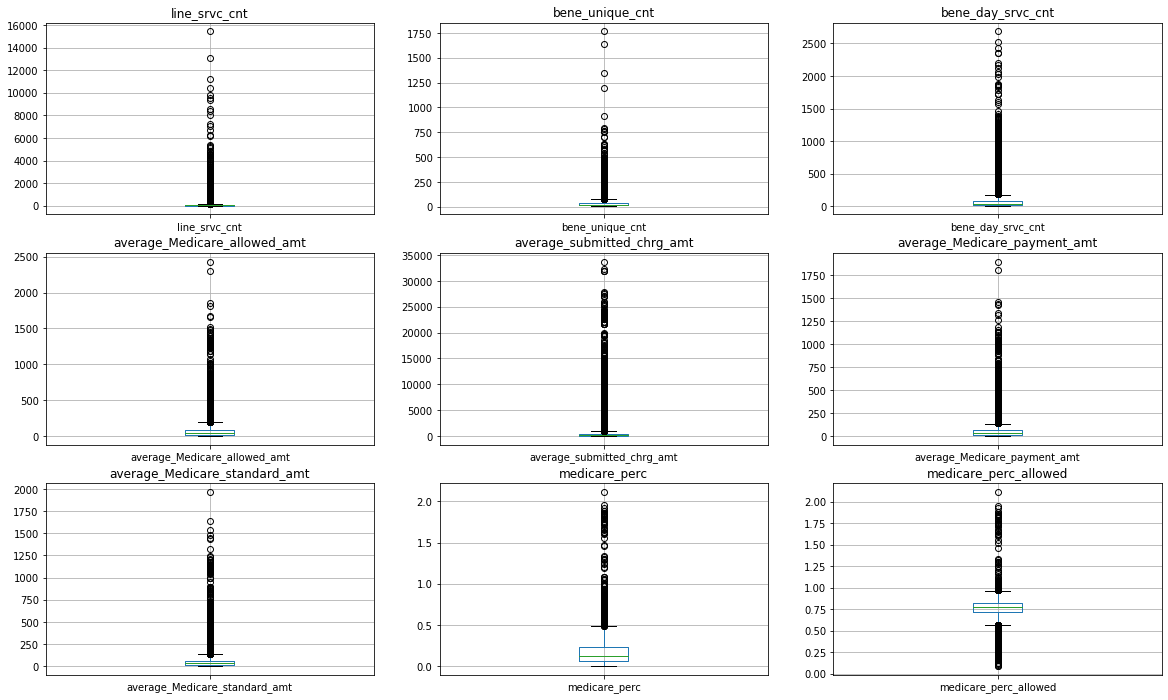

In [19]:
plt.rcParams['figure.figsize'] = [20, 12]
for pos, val in enumerate(numerical): 
    plt.subplot(3, 3, pos+1)
    data[numerical].boxplot(column = val)
    plt.title(val)
plt.savefig('img/box_and_whisker.png')
plt.show()

### <u> (3) Checking correlation between numerical columns </u>

In [21]:
correlations = data[numerical].corr(method ='pearson')
correlations

,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,medicare_perc,medicare_perc_allowed
line_srvc_cnt,1.000,0.293,0.428,-0.084,-0.069,-0.080,-0.079,0.077,0.003
bene_unique_cnt,0.293,1.000,0.571,-0.063,-0.068,-0.062,-0.061,-0.003,0.018
bene_day_srvc_cnt,0.428,0.571,1.000,-0.089,-0.101,-0.088,-0.085,0.293,0.003
average_Medicare_allowed_amt,-0.084,-0.063,-0.089,1.000,0.686,0.995,0.995,-0.040,0.010
average_submitted_chrg_amt,-0.069,-0.068,-0.101,0.686,1.000,0.688,0.683,-0.210,0.024
average_Medicare_payment_amt,-0.080,-0.062,-0.088,0.995,0.688,1.000,0.994,-0.051,0.047
average_Medicare_standard_amt,-0.079,-0.061,-0.085,0.995,0.683,0.994,1.000,-0.033,0.070
medicare_perc,0.077,-0.003,0.293,-0.040,-0.210,-0.051,-0.033,1.000,0.116
medicare_perc_allowed,0.003,0.018,0.003,0.010,0.024,0.047,0.070,0.116,1.000


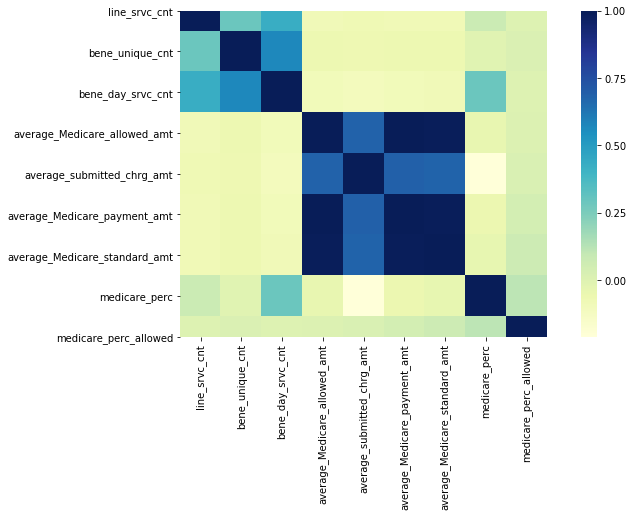

In [22]:
# plot correlation matrix
f, ax = plt.subplots(figsize=(12, 6))
heatmap = sns.heatmap(correlations, mask=np.zeros_like(correlations, dtype=np.bool),
            cmap="YlGnBu",
            square=True, ax=ax)
f.savefig("img/heatmap_pearson.png", bbox_inches="tight")

In [23]:
data[numerical].corr(method ='spearman')

,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,medicare_perc,medicare_perc_allowed
line_srvc_cnt,1.000,0.769,0.965,-0.200,-0.351,-0.196,-0.187,0.272,-0.037
bene_unique_cnt,0.769,1.000,0.804,-0.087,-0.111,-0.089,-0.083,0.070,-0.045
bene_day_srvc_cnt,0.965,0.804,1.000,-0.143,-0.305,-0.141,-0.131,0.309,-0.040
average_Medicare_allowed_amt,-0.200,-0.087,-0.143,1.000,0.767,0.988,0.988,0.212,-0.103
average_submitted_chrg_amt,-0.351,-0.111,-0.305,0.767,1.000,0.780,0.763,-0.377,-0.021
average_Medicare_payment_amt,-0.196,-0.089,-0.141,0.988,0.780,1.000,0.994,0.201,-0.016
average_Medicare_standard_amt,-0.187,-0.083,-0.131,0.988,0.763,0.994,1.000,0.224,0.000
medicare_perc,0.272,0.070,0.309,0.212,-0.377,0.201,0.224,1.000,-0.095
medicare_perc_allowed,-0.037,-0.045,-0.040,-0.103,-0.021,-0.016,0.000,-0.095,1.000


### <u> (4) Transfomring each numerical column</u>

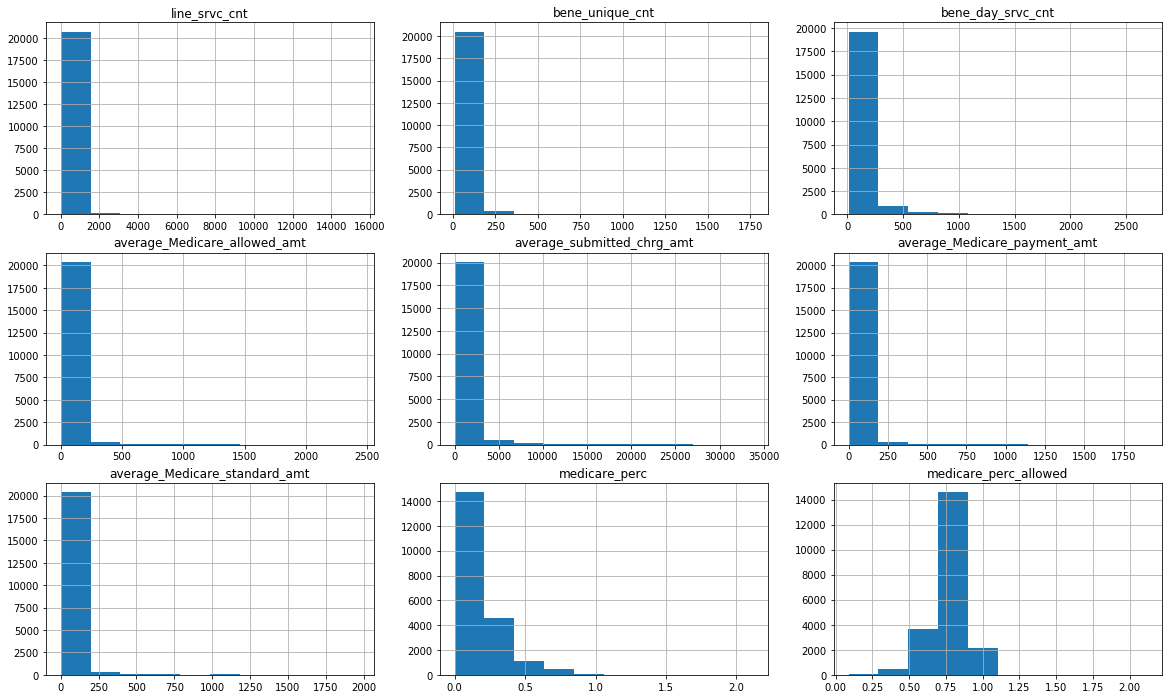

In [24]:
plt.rcParams['figure.figsize'] = [20, 12]
for pos, val in enumerate(numerical): 
    plt.subplot(3, 3, pos+1)
    data[val].hist()
    plt.title(val)
plt.savefig('img/distribution_before_transformation.png')
plt.show()

line_srvc_cnt's lambda: -0.403
bene_unique_cnt's lambda: -0.627
bene_day_srvc_cnt's lambda: -0.410
average_Medicare_allowed_amt's lambda: 0.177
average_submitted_chrg_amt's lambda: -0.065
average_Medicare_payment_amt's lambda: 0.152
average_Medicare_standard_amt's lambda: 0.155
medicare_perc's lambda: 0.160
medicare_perc_allowed's lambda: 0.931


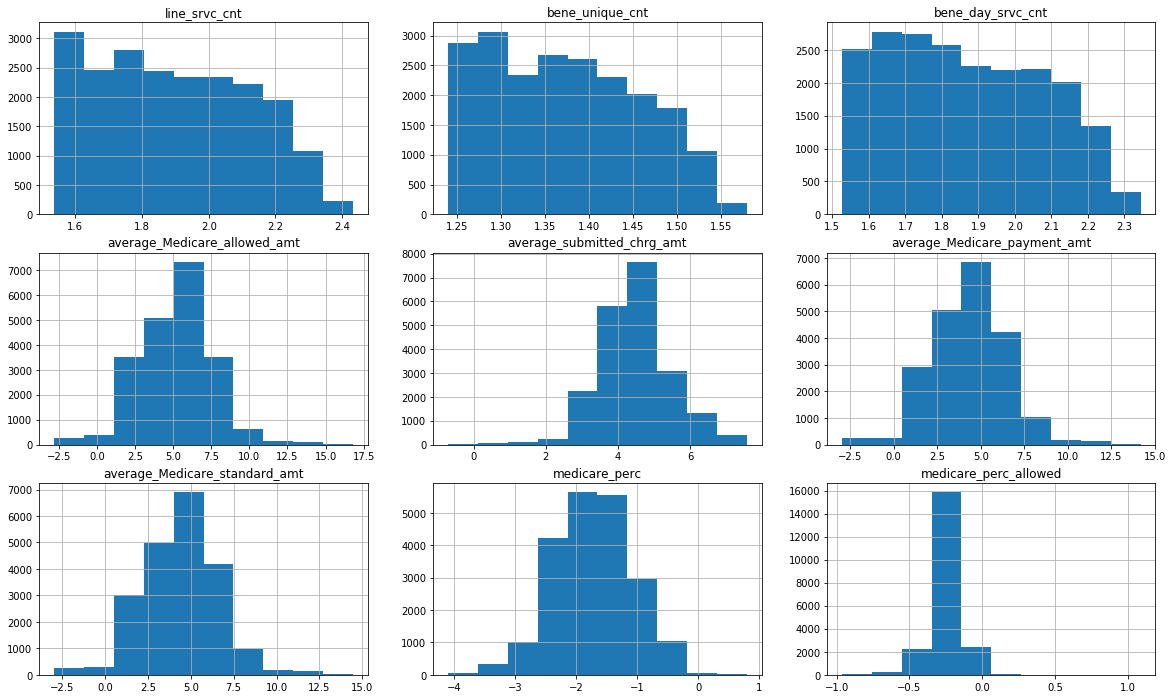

,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,medicare_perc,medicare_perc_allowed
count,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000
mean,1.898,1.372,1.865,5.172,4.456,4.342,4.438,-1.721,-0.231
std,0.224,0.086,0.211,2.442,1.001,2.128,2.162,0.654,0.124
min,1.538,1.240,1.527,-2.800,-0.706,-2.956,-2.944,-4.100,-0.962
25%,1.708,1.302,1.676,3.607,3.779,2.889,2.975,-2.184,-0.286
50%,1.883,1.371,1.850,5.288,4.446,4.421,4.528,-1.739,-0.220
75%,2.083,1.441,2.041,6.802,5.002,5.707,5.818,-1.282,-0.183
max,2.432,1.579,2.344,16.787,7.561,14.170,14.440,0.798,1.087


In [25]:
data_new = copy.deepcopy(data)
plt.rcParams['figure.figsize'] = [20, 12]
for pos, val in enumerate(numerical): 
    plt.subplot(3, 3, pos+1)
    data_new[val],lmbda = boxcox(data_new[val]+0.001, lmbda = None)
    print(val+ "\'s lambda: %0.3f" % lmbda)
    data_new[val].hist()
    plt.title(val)
plt.savefig('img/distribution_after_transformation.png')
plt.show()

data_new[numerical].describe()

# Clustering (K-means)

### <u> 1. Selecting columns for clustering & one-hot encoding</u> 

In [26]:
selected_categorical = ['nppes_provider_gender','nppes_entity_code', 
       'medicare_participation_indicator', 'place_of_service','hcpcs_drug_indicator']
selected_numerical = ["bene_day_srvc_cnt", "bene_unique_cnt", "average_Medicare_allowed_amt"]
features = data_new[selected_categorical + selected_numerical]
for i in selected_categorical:
    dummies = pd.get_dummies(features[i], prefix = i)
    features = pd.concat([features, dummies], axis = 1)
    del features[i]
features.head()

,bene_day_srvc_cnt,bene_unique_cnt,average_Medicare_allowed_amt,nppes_provider_gender_F,nppes_provider_gender_M,nppes_entity_code_I,medicare_participation_indicator_N,medicare_participation_indicator_Y,place_of_service_F,place_of_service_O,hcpcs_drug_indicator_N,hcpcs_drug_indicator_Y
0,1.896,1.434,3.037,0,1,1,0,1,1,0,1,0
1,2.033,1.491,3.073,0,1,1,0,1,1,0,1,0
2,1.739,1.358,3.980,1,0,1,0,1,0,1,1,0
3,1.694,1.334,6.188,0,1,1,0,1,1,0,1,0
4,1.765,1.289,6.295,1,0,1,0,1,0,1,1,0


In [27]:
features.describe()

,bene_day_srvc_cnt,bene_unique_cnt,average_Medicare_allowed_amt,nppes_provider_gender_F,nppes_provider_gender_M,nppes_entity_code_I,medicare_participation_indicator_N,medicare_participation_indicator_Y,place_of_service_F,place_of_service_O,hcpcs_drug_indicator_N,hcpcs_drug_indicator_Y
count,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000
mean,1.865,1.372,5.172,0.462,0.538,1.000,0.001,0.999,0.417,0.583,0.978,0.022
std,0.211,0.086,2.442,0.499,0.499,0.000,0.027,0.027,0.493,0.493,0.145,0.145
min,1.527,1.240,-2.800,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.676,1.302,3.607,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000
50%,1.850,1.371,5.288,0.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000
75%,2.041,1.441,6.802,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000
max,2.344,1.579,16.787,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


### <u> 2. Normalizing every column</u> 

In [28]:
scaler = StandardScaler()
dfNorm = scaler.fit_transform(features)
dfNorm = pd.DataFrame(dfNorm)
dfNorm.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000,20955.000
mean,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.603,-1.537,-3.264,-0.927,-1.079,0.000,-0.027,-37.363,-0.846,-1.182,-6.727,-0.149
25%,-0.895,-0.812,-0.641,-0.927,-1.079,0.000,-0.027,0.027,-0.846,-1.182,0.149,-0.149
50%,-0.068,-0.018,0.047,-0.927,0.927,0.000,-0.027,0.027,-0.846,0.846,0.149,-0.149
75%,0.837,0.795,0.667,1.079,0.927,0.000,-0.027,0.027,1.182,0.846,0.149,-0.149
max,2.274,2.395,4.756,1.079,0.927,0.000,37.363,0.027,1.182,0.846,0.149,6.727


### <u> 3. Finding appropriate K</u> 

In [29]:
inertia = []
silh = []
K = range(2,20)
for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(dfNorm)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_)
    silh.append(silhouette_avg)

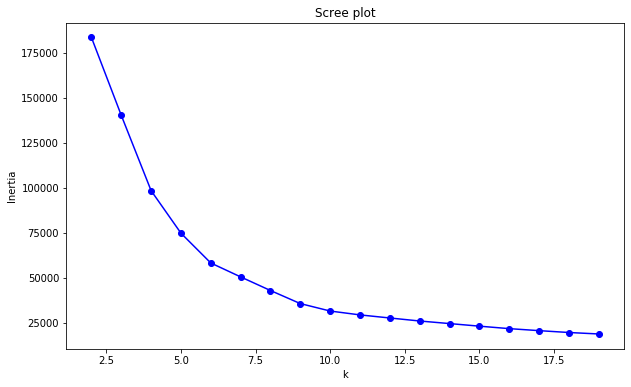

In [30]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.plot(K, inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Scree plot')
plt.savefig('img/scree_plot.png')
plt.show()

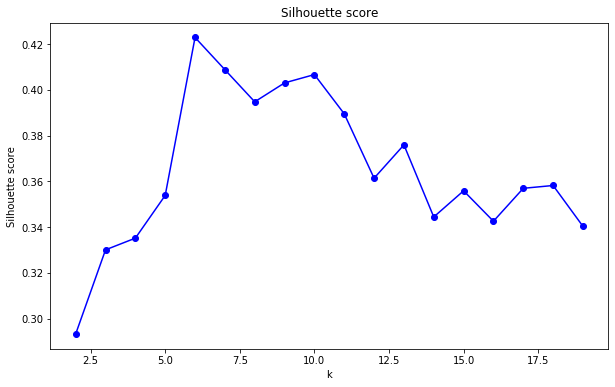

In [31]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.plot(K, silh, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')
plt.savefig('img/silhoutte_score.png')
plt.show()

### <u> 4. Clustering with chosen K</u> 

In [40]:
selected = 6
kmeans = KMeans(n_clusters = selected, random_state = 1).fit(dfNorm)
k_means_labels = kmeans.labels_
for i in range(selected):
    print(i+1)
    print(list(k_means_labels).count(i))
    print("====")

1
5529
====
2
5424
====
3
453
====
4
6219
====
5
3315
====
6
15
====


In [41]:
data["Cluster"] = k_means_labels+1

In [42]:
data.to_csv("data/added.csv")